In [1]:
import os, sys, time, glob, warnings
from os.path import join as joindir
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64
import scipy
from scipy import interpolate
from scipy.interpolate import griddata

warnings.filterwarnings('ignore')

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

In [2]:
ds_prof=xr.open_dataset("../data/osb_ctd_jul21_temperature.nc")
ds_roms=xr.open_dataset("../data/roms_osb_july_2021.nc")

In [3]:
# Find upper layer index in ROMS output
upper_id = []
for i in range(ds_roms.z_rho.data.shape[0]):
    upper_id.append(np.where(ds_roms.z_rho.data[i,:]>=-200)[0][0])

#print(upper_id)

In [4]:
### Resampling and interpolation for comparison

# Dimensions
NT = 31*24 # hours
# Resampling profiler data every hour (exclude time @ 00:00:00 for now)
temp_prof = np.reshape(ds_prof.temperature.data[1:],(NT,60))
depth_prof = np.reshape(ds_prof.z.data[1:],(NT,60))
time_prof = np.reshape(ds_prof.time.data[1:],(NT,60))

temp_roms = ds_roms.temp.data[1:,21:]
time_roms = ds_roms.ocean_time.data[1:]
depth_roms = ds_roms.z_rho.data[1:,21:]


temp_extrap = np.ones(temp_roms.shape)*np.nan
for t in range(NT):
    # 1D interpolation using scipy, could try different methods (kind='linear','nearest')
    f = interpolate.interp1d(depth_prof[t,:], temp_prof[t,:], kind='nearest',fill_value="extrapolate")
    temp_extrap[t,:] = f(depth_roms[t,:])


At depth around -73.3223789134921m


Text(0, 0.5, 'Temp [$^\\circ C$]')

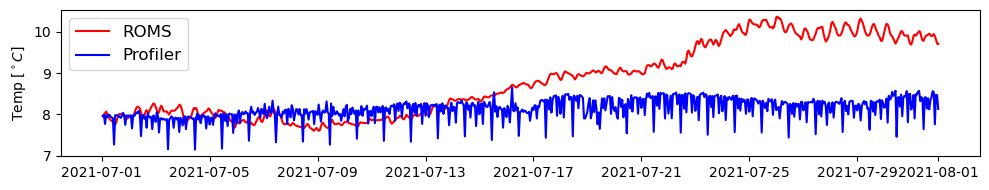

In [5]:
# Compare time-series at a selected depth
zid = 3 # ranges 0~8, from ~200m to the surface
print('\nAt depth around {}m'.format(depth_roms[:,zid].mean()))
fig0, ax = plt.subplots(1, 1, figsize=(10,2), tight_layout=True)
ax.plot(time_roms, temp_roms[:,zid],'r-',label='ROMS')
ax.plot(time_roms, temp_extrap[:,zid],'b-',label='Profiler')
ax.legend(loc='best',fontsize=12)
ax.set_ylabel('Temp [$^\circ C$]', size=10)

The 1D interpolation does not work very well.

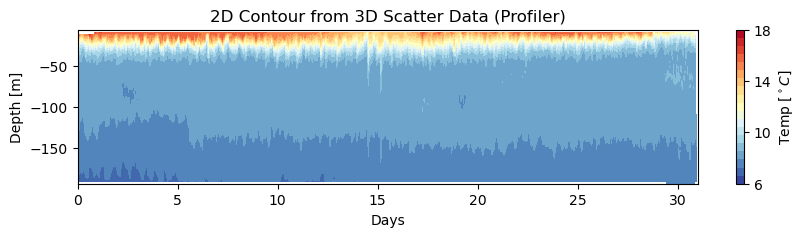

In [6]:
# First reconstruct scatter data (from profiler) to 2D contour
NT = len(ds_prof.time.data)
# Resampled every hour & every 3 m (from -194m to -5m)
grid_t, grid_z = np.mgrid[0:NT:745j, -194:-5:63j]  # j means we want a complex number with 0 imaginary part, which gives the number of points

# Use griddata for interpolation
prof_int = griddata((np.arange(NT), ds_prof.z.data), ds_prof.temperature.data, (grid_t, grid_z), method='linear')

# Plot the contour
fig1 = plt.figure(figsize=(10, 2))
contour = plt.contourf(grid_t/(24*60), grid_z, prof_int, np.linspace(6,18,20), cmap="RdYlBu_r")
cbar = plt.colorbar(contour)
cbar.set_ticks([6,10,14,18])
cbar.set_label(r'Temp $[^\circ C]$', fontsize=10)
plt.title("2D Contour from 3D Scatter Data (Profiler)")
plt.xlabel("Days")
plt.ylabel("Depth [m]")

fig1.savefig('./Figs/osb_july_temp_resample.png', dpi=300, bbox_inches='tight') 

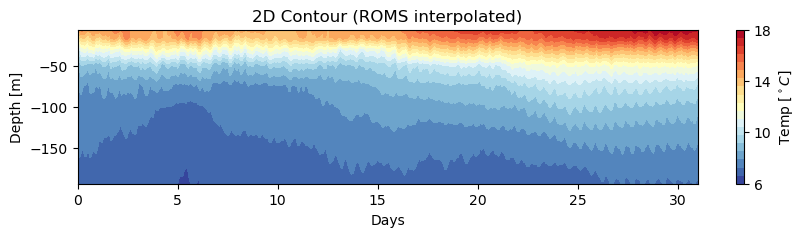

In [7]:
# Interpolate ROMS data to the same grid

#Ot, Srho = np.meshgrid(np.arange(745), ds_roms.s_rho, indexing='ij')

roms_int = np.ones(prof_int.shape)*np.nan
for t in range(745):
    # 1D interpolation using scipy, could try out different methods (kind='linear','nearest')
    f = interpolate.interp1d(ds_roms.z_rho.data[t,:], ds_roms.temp.data[t,:], kind='linear')
    roms_int[t,:] = f(grid_z[1,:])

# Plot the contour
fig2 = plt.figure(figsize=(10, 2))
contour = plt.contourf(grid_t/(24*60), grid_z, roms_int, np.linspace(6,18,20), cmap="RdYlBu_r")
cbar = plt.colorbar(contour)
cbar.set_ticks([6,10,14,18])
cbar.set_label(r'Temp $[^\circ C]$', fontsize=10)
plt.title("2D Contour (ROMS interpolated)")
plt.xlabel("Days")
plt.ylabel("Depth [m]")

fig2.savefig('./Figs/roms_july_temp_resample.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Depth [m]')

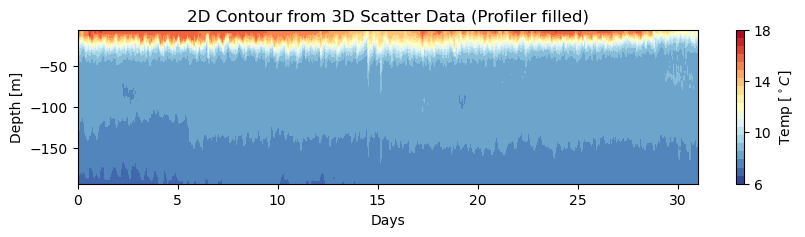

In [8]:
# Optional?
# There're still some NaNs, could use further interpolation

from scipy.interpolate import NearestNDInterpolator
mask_t = np.where(~np.isnan(prof_int))
interp_t = NearestNDInterpolator(np.transpose(mask_t), prof_int[mask_t])
prof_filled = interp_t(*np.indices(prof_int.shape))

plt.figure(figsize=(10, 2))
contour = plt.contourf(grid_t/(24*60), grid_z, prof_filled, np.linspace(6,18,20), cmap="RdYlBu_r")
cbar = plt.colorbar(contour)
cbar.set_ticks([6,10,14,18])
cbar.set_label(r'Temp $[^\circ C]$', fontsize=10)
plt.title("2D Contour from 3D Scatter Data (Profiler filled)")
plt.xlabel("Days")
plt.ylabel("Depth [m]")

## New variables obtained so far
`prof_int`: temperature from the profiler after interpolation and reconstruction \
`rom_int`: temperature from the ROMS after interpolating to the new grid from `prof_int` \
`prof_filled`: further interpolated `prof_int` to remove NaNs \
`grid_t`: new time grid in minute, size=745$\times$63 \
`grid_z`: new depth grid in m, size=745$\times$63

In [9]:
#grid_t[:,1]
grid_z[1,:] 

array([-194.        , -190.9516129 , -187.90322581, -184.85483871,
       -181.80645161, -178.75806452, -175.70967742, -172.66129032,
       -169.61290323, -166.56451613, -163.51612903, -160.46774194,
       -157.41935484, -154.37096774, -151.32258065, -148.27419355,
       -145.22580645, -142.17741935, -139.12903226, -136.08064516,
       -133.03225806, -129.98387097, -126.93548387, -123.88709677,
       -120.83870968, -117.79032258, -114.74193548, -111.69354839,
       -108.64516129, -105.59677419, -102.5483871 ,  -99.5       ,
        -96.4516129 ,  -93.40322581,  -90.35483871,  -87.30645161,
        -84.25806452,  -81.20967742,  -78.16129032,  -75.11290323,
        -72.06451613,  -69.01612903,  -65.96774194,  -62.91935484,
        -59.87096774,  -56.82258065,  -53.77419355,  -50.72580645,
        -47.67741935,  -44.62903226,  -41.58064516,  -38.53225806,
        -35.48387097,  -32.43548387,  -29.38709677,  -26.33870968,
        -23.29032258,  -20.24193548,  -17.19354839,  -14.14516


At depth around -47.67741935483872m


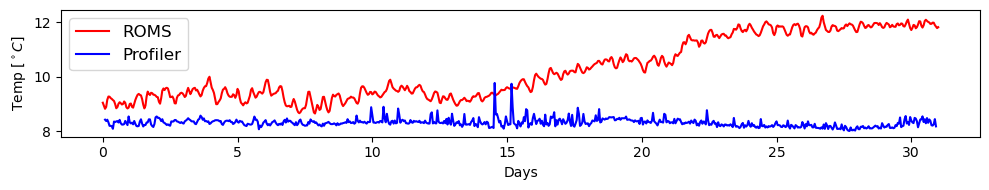

In [11]:
# Time Series comparison at a selected depth

z0 = -15 # from -194m to -5m
print('\nAt depth around {}m'.format(grid_z[1,z0]))
fig3, ax = plt.subplots(1, 1, figsize=(10,2), tight_layout=True)
ax.plot(np.arange(745)/24, roms_int[:,z0],'r-',label='ROMS')
ax.plot(np.arange(745)/24, prof_int[:,z0],'b-',label='Profiler')
ax.legend(loc='best',fontsize=12)
ax.set_xlabel('Days', size=10)
ax.set_ylabel('Temp [$^\circ C$]', size=10)

fig3.savefig('./Figs/temp_time-series.png', dpi=300, bbox_inches='tight')

In [13]:
grid_z[1,z0]

-47.67741935483872

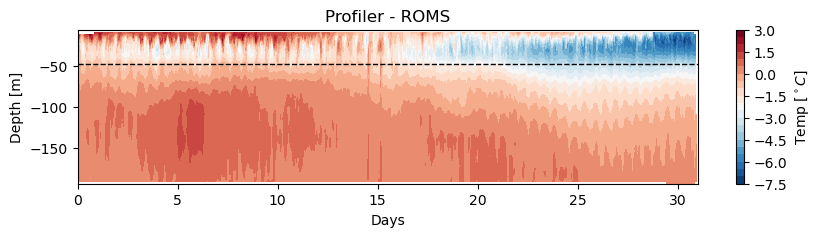

In [17]:
# Divergence in contour plot
fig4 = plt.figure(figsize=(10, 2))
ax = fig4.add_subplot(111)
contour = ax.contourf(grid_t/(24*60), grid_z, prof_int-roms_int, 20, cmap="RdBu_r")
ax.axhline(y=grid_z[1,z0], ls='--', color='k',lw=1)
cbar = plt.colorbar(contour)
#cbar.set_ticks([6,10,14,18])
cbar.set_label(r'Temp $[^\circ C]$', fontsize=10)
plt.title("Profiler - ROMS")
plt.xlabel("Days")
plt.ylabel("Depth [m]")
fig4.savefig('./Figs/temp_divergence_contour', dpi=300, bbox_inches='tight')

In [27]:
#len(grid_t[:,1]), len(ds_roms.ocean_time.values)
#ds_roms.ocean_time.values
#np.shape(grid_t[:,1])

(745,)

In [28]:
# Save interpolated results

# Construct the dataset using data_vars
output_ds = xr.Dataset(
    data_vars={
        'temp_prof': (('time', 'depth'), prof_int),
        'temp_prof_filled': (('time', 'depth'), prof_filled),
        'temp_roms': (('time', 'depth'), roms_int),
        'ocean_time': ('time', ds_roms.ocean_time.values)
    },
    coords={
        'depth': grid_z[1,:],
        'time': grid_t[:,1]
    }
)

output_ds.to_netcdf('./temperature_interp.nc')